In [1]:
!pip install obspy wget

In [2]:
import obspy
import numpy as np
import scipy
import pandas as pd
import h5py
from obspy.clients.fdsn.client import Client 
client= Client("IRIS")
from scipy.signal import decimate, butter,filtfilt
import matplotlib.pyplot as plt
import wget
import scipy.signal as signal
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
import matplotlib.dates as mdates

# datetime interaction
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime

In [12]:
# read in data
df = pd.read_csv("C:/Users/wolfn/.seisbench/datasets/comcat/comcat_metadata.csv")
df2 = pd.read_csv("C:/Users/wolfn/.seisbench/datasets/comcat/miniPNW_metadata.csv")
df.shape

(183909, 36)

In [4]:
df['preferred_source_magnitude_type'].unique()

array(['md', 'ml', 'mh'], dtype=object)

In [5]:
f = h5py.File("C:/Users/wolfn/.seisbench/datasets/comcat/comcat_waveforms.hdf5", "r")
f2 = h5py.File("C:/Users/wolfn/.seisbench/datasets/comcat/miniPNw_waveforms.hdf5", "r")

In [13]:
def read_data(df: pd.DataFrame, index: int, apply_filter = None, freq = None, freqmax = None, freqmin = None):
    """
    This function taks in a dataframe and some index from that dataframe. Can add filters if desired. 
    Returns stream object, p-wave arrival time, s-wave arrival time, and distance between event and seismogram in km
    """
    # read in metadata
    source_id = df.iloc[index]['event_id']
    net = df.iloc[index]['station_network_code']
    sta = df.iloc[index]['station_code']
    loc =  df.iloc[index]['station_location_code']
    cha = df.iloc[index]['trace_channel'] # switched form station channel code -> trace_channel
    sample_p = df.iloc[index]['trace_P_arrival_sample']
    sample_s = df.iloc[index]['trace_S_arrival_sample']
    trace_starttime = df.iloc[index]['trace_start_time']
    sample_rate = df.iloc[index]['trace_sampling_rate_hz']


    # calculate the distance
    

    # station latitude and longitude
    slat = df.iloc[index]['station_latitude_deg']
    slon = df.iloc[index]['station_longitude_deg']


    # source latitude and longitude
    lat0 = df.iloc[index]['source_latitude_deg'] 
    lon0 = df.iloc[index]['source_longitude_deg']


    # Use Obspy.gps2dist_azimuth to calc great circle distance in meters, azimuth A->B in degrees, azimuth B->A in degrees
    dist,az,baz=gps2dist_azimuth(lat0,lon0,slat,slon)



    # read the data

    # Store trace name in tn so that we can use it to grab waveform from hdf5 file
    tn = df.iloc[index]['trace_name']
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    # print(x,y,z)
    data = f['/data/%s' % bucket][x, :y, :z]


    # Create stream object

    stream = obspy.Stream()


    for i in range(3):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.sampling_rate = df.iloc[index]['trace_sampling_rate_hz']
        tr.stats.starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
        tr.stats.station = sta
        tr.stats.network = net
        tr.stats.location = loc
        if i == 0:
          tr.stats.channel = cha+"E"
        elif i == 1:
          tr.stats.channel = cha+"N"
        else :
          tr.stats.channel = cha+"Z"
        stream.append(tr)

    if apply_filter == 'bandpass':
        stream.filter(apply_filter, freqmin = freqmin, freqmax = freqmax)
    elif apply_filter is not None:
        stream.filter(apply_filter, freq = freq)

    #Phase pick and arrival time info

    starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
    x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(15001)]
    p_time = sample_p/sample_rate 
    s_time = sample_s/sample_rate


    return stream, p_time, s_time, dist/1000

In [9]:
tr, tp, ts, dist = read_data(df, 3)
print(tr[0].stats.starttime)
tp1 = UTCDateTime(tr[0].stats.starttime) + tp
print(tp1)

2002-10-03T01:55:59.530000Z
2002-10-03T01:56:53.950000Z


In [10]:
ps_ratio = np.zeros(183909)
ps_rat = pd.Series(ps_ratio)


183909

In [952]:
for i in range(0, 183909):
    # i = 0
    # read data, get stream object (tr), p-time (tp), s-time (ts), and dist btwn event and seismogram (dist)
    tr, tp, ts, dist = read_data(df, i)
    # print(tr[0].stats.starttime)
    tp1 = UTCDateTime(tr[0].stats.starttime) + tp
    ts1 = UTCDateTime(tr[0].stats.starttime) + ts

    station = df.iloc[i]['station_code']
    if df.iloc[i]["station_location_code"] == "--":
        thissta = df.iloc[i]["station_network_code"] + "."+ df.iloc[i]["station_code"] + ".." + df.iloc[i]["trace_channel"] + "Z"
    else:
        thissta = df.iloc[i]["station_network_code"] + "."+ df.iloc[i]["station_code"] + "."+df.iloc[i]["station_location_code"] + "." + df.iloc[i]["trace_channel"] + "Z"


    inv0 = client.get_stations(network = df.iloc[i]["station_network_code"],\
                            station = df.iloc[i]["station_code"],\
                            location = "*",\
                            channel = df.iloc[i]["trace_channel"] + "*",\
                            starttime = UTCDateTime(2002,1,1),\
                            endtime = UTCDateTime(2022,12,1),\
                            level = "response")


    # remove instrumental response
    PAZ = inv0.get_response(thissta, tr[0].stats.starttime).get_paz()
    paz_sta = {'gain': PAZ.stage_gain,
                'poles': PAZ.poles,
                'sensitivity': PAZ.normalization_factor*PAZ.stage_gain,
                'zeros': PAZ.zeros}
    tr.simulate(paz_remove = paz_sta, water_level = 10)

    # filter 1 - 20 hz ??? make sure this is part of our project
    tr.filter('bandpass',freqmin = 1,freqmax = 20,corners = 2,zerophase = True)  # will do 1 - 20 **********
    # calculate envelope using the obspy function of the vertical component, and then its log
    # data_envelope = np.log10(obspy.signal.filter.envelope(tr[2].data))
    tr2 = tr[2].copy()
    # tr2.data[:] = data_envelope

    # Calculate the time where the envelope hits 2 times the noise floor. This is our NOISE VALUE to remove from P and S 

    noise = tr.copy()
    noise.trim(tp1 - 12, tp1 - 2)  
    noise_value = np.sum(noise[0].data**2 + noise[1].data**2 + noise[2].data**2)


    # Calculate the P-wave values

    wave_p = tr.copy()
    wave_p.trim(tp1 - 2, tp1 + 8)  
    wavep_value = np.sum(wave_p[0].data**2 + wave_p[1].data**2 + wave_p[2].data**2)

    # Calculate the S-wave values

    wave_s = tr.copy()
    wave_s.trim(ts1 - 2, ts1 + 8)  
    wave_s_value = np.sum(wave_s[0].data**2 + wave_s[1].data**2 + wave_s[2].data**2)

    # Put it all together- Calculate the P/S ratio
    # need to create new series with all newly calculated ps ratios. append to end of df

    ps_rat[i] = np.sqrt(wavep_value - noise_value) / np.sqrt( wave_s_value - noise_value)
    # print("Source type: ", df['source_type'][i], "P/S ratio:", ps_ratio[i])

# print(ps_ratio)

c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
 

In [1018]:
# list of indices where we ran into an error
fail_list = [112289,114255,140476,140482,156214,156583,156763,156848,157130,157207,157440,157700,161960,166096,166192,166245,166313,166618,167685,167804,168620,171893]
ps_ratio = ps_rat
num_nans = ps_ratio.isna().sum()
num_zeros= (ps_ratio == 0).sum()
print("# NaNs:", num_nans, "\n", "# zeros:", num_zeros, "\n")

# NaNs: 1593 
 # zeros: 22 



In [1019]:
final_df = pd.concat([df, ps_ratio], axis=1) 
final_df = final_df.rename(columns={0: 'ps_ratio'})
print(final_df.shape, '\n', list(final_df.keys()))

(183909, 37) 
 ['event_id', 'source_origin_time', 'source_latitude_deg', 'source_longitude_deg', 'source_type', 'source_depth_km', 'preferred_source_magnitude', 'preferred_source_magnitude_type', 'preferred_source_magnitude_uncertainty', 'source_depth_uncertainty_km', 'source_horizontal_uncertainty_km', 'station_network_code', 'trace_channel', 'station_code', 'station_location_code', 'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m', 'trace_name', 'trace_sampling_rate_hz', 'trace_start_time', 'trace_S_arrival_sample', 'trace_P_arrival_sample', 'trace_S_arrival_uncertainty_s', 'trace_P_arrival_uncertainty_s', 'trace_P_polarity', 'trace_S_onset', 'trace_P_onset', 'trace_snr_db', 'year', 'source_type_pnsn_label', 'source_local_magnitude', 'source_local_magnitude_uncertainty', 'source_duration_magnitude', 'source_duration_magnitude_uncertainty', 'source_hand_magnitude', 'ps_ratio']


In [1021]:
# 3 arrays : ps ratio, eventid, list of unique event id
# Take the median of all ps ratios for each uniqe event id
event_ps = final_df.groupby('event_id')['ps_ratio'].median()
print(event_ps.shape,"\n", event_ps.head(10))


(46614,) 
 event_id
uw10547658    1.056651
uw10547683    0.997685
uw10547718    0.509350
uw10547793    1.099857
uw10547863    1.009636
uw10547878    0.866931
uw10547893    1.011369
uw10547973    0.971075
uw10548058    0.974169
uw10548073    0.988482
Name: ps_ratio, dtype: float64


## Calculating Duration Magnitude

Comparison with a coda duration magnitude. First, we will plot the data in log(amp) to see noise levels and coda amplitude decay.


We will follow a similar process that the University of Utah to calculate the duration magnitude (Koper et al., 2021) and some of the notes from the PNSN process.

The workflow to measure duration may be as follow:

1. Select all vertical seismograms all channels
2. remove instrumental response to ground velocity in m/s
3. filter the data wth a 4th pole butterworth bandpass between 1 and 10 Hz.
4. take the envelope of the seismograms ($\sqrt{ x^2(t) + H(x(t))^2}$)
5. take the $log_{10}$ of the envelope.
6. $t_P$ is the P-wave arrival time.
7. $t_S$ is the S-wave arrival time.
8. $t_{peak}$ is the time of maximum amplitude after the S.
9. the noise is the average value of the envelope in a 10 s window starting 12 s before the theoretical P-wave arrival time (tP).
10. the duration $T_D = t_3-t_{peak}$ 
11. calculate the moment duration using the equation: $M_D = -1.61 + 2.82*log10(T_D)$ , where $\Delta$ is the source receiver distance. $M_d$ is taken as the median of at least 3 station-estimates. 
# NEED TO REWORK $M_D$ to find new coefficients to replace  -1.61 and 2.82 parameter

In [1016]:

# let's select a station
# import time as time
md_true=np.zeros(183909)
log_Td = np.zeros(183909)



for i in range(0,200):
  tr, tp, ts, dist = read_data(df, i)

  tp1 = UTCDateTime(tr[0].stats.starttime) + tp
  ts1 = UTCDateTime(tr[0].stats.starttime) + ts
  

  # remove the instrumental zone and convolve with wood anderson
  station = df.iloc[i]["station_code"]
  if df.iloc[i]["station_location_code"] == "--":
    thissta = df.iloc[i]["station_network_code"] + "." + df.iloc[i]["station_code"] + ".." + df.iloc[i]['trace_channel'] + "Z"
  else:
    thissta = df.iloc[i]["station_network_code"] + "." + df.iloc[i]["station_code"] + "." + df.iloc[i]["station_location_code"] + "." + df.iloc[i]['trace_channel']+"Z"

  inv0 = client.get_stations(network = df.iloc[i]["station_network_code"],\
                              station = df.iloc[i]["station_code"],\
                              location = "*",\
                              channel = df.iloc[i]['trace_channel']+"*",\
                            starttime = UTCDateTime(2002,1,1),endtime=UTCDateTime(2022,12,1),level="response")
  # remove response
  PAZ = inv0.get_response(thissta,tr[0].stats.starttime).get_paz()
  paz_sta = {'gain': PAZ.stage_gain,
              'poles': PAZ.poles,
              'sensitivity': PAZ.normalization_factor*PAZ.stage_gain,
              'zeros': PAZ.zeros}
  tr.simulate(paz_remove=paz_sta, water_level=10)
  # filter 1-10Hz
  tr.filter('bandpass',freqmin=1,freqmax=10,corners=2,zerophase=True)  # will do 1 - 20 **********
  # calculate envelope using the obspy function of the vertical component, and then its log
  data_envelope = obspy.signal.filter.envelope(tr[2].data)
  tr2 = tr[2].copy()
  tr2.data[:]=np.log10(data_envelope)

  # calculate the time at which the envelope hits 2 times the noise floor
  noise = tr.copy()
  noise[0].data = data_envelope
  noise.trim(tp1 - 12,tp1 - 2)  
  nnoise_value = np.sum(noise[2].data**2)  # This is our noise value
  # noise[0].data**2 + noise[1].data**2 
  # fig=plt.figure()
  # plt.plot(tr2.data)
  # wave_p = tr.copy()
  # wave_p.trim(tp1 - 2,tp1 + 8)  
  # wavep_value = np.sum(wave_p[0].data**2 + wave_p[1].data**2 + wave_p[2].data**2)
  # wave_s = tr.copy()
  # wave_s.trim(ts1 - 2, ts1 + 8)  
  # wave_s_value = np.sum(wave_s[0].data**2 + wave_s[1].data**2 + wave_s[2].data**2)


  # ps_ratio = np.sqrt(wavep_value - nnoise_value) / np.sqrt( wave_s_value - nnoise_value)  #### this is our p/s ratio 
  # # time of pick

  wave = tr2.copy()
  wave = tr2.trim(tr2.stats.starttime + tp, tr2.stats.starttime + tp + ts + 30)
  
  # get the first element of the time series where the envelope is 

  # plt.plot(tr2.data-np.log10(2*10**nnoise_value),'r');plt.grid(True)
  # print(nnoise_value,tr.stats,len(wave[0].data))
  # print(len(wave.data[wave.data>=np.log10(2*10**nnoise_value)]))
  Td = len(wave.data[wave.data >= np.log10(2*nnoise_value)]) / tr2.stats.sampling_rate #duration
  # print("Td:", Td,  )
  log_Td[i] = np.log10(Td)

  md_true[i]=df.iloc[i]["source_duration_magnitude"]

# Need to solve for new coefficients in --> MD = a + b*log10(Td)
# Will have many MD's (y value) and Td's (x value) 
# Use stats.linregress to find new coefficients a and b. b will be slope, a will be intercept 
# Log_Td vs md_true

c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)
c:\Users\wolfn\anaconda3\envs\PNSN\lib\site-packages\obspy\core\inventory\response.py:1935: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
 

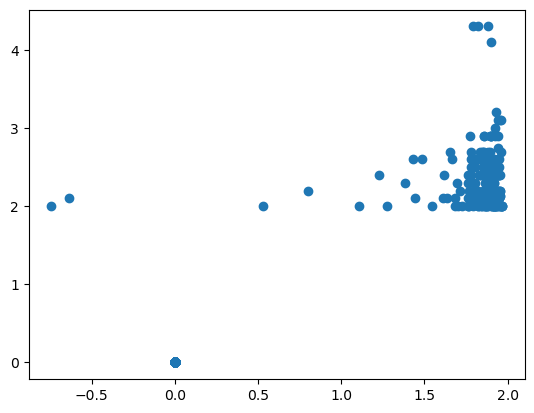

In [1017]:
# Not working out how we expected
plt.scatter(log_Td, md_true)